# Case #1 - Dating Application
You work as an analyst for an online dating application.

The mechanics of the application are as follows: users view each other's profiles in the app and can either like or dislike them. If two users like each other's profiles, it's called a "match," and they are given the opportunity to get to know each other.

The application team has developed a new algorithm to find the most suitable profiles for users. To test the effectiveness of the algorithm, an A/B test was conducted. All users were divided into two groups. Users in group 0 used the app with the old algorithm, while all users in group 1 used the app with the new algorithm for profile matching.

Your task is to evaluate whether the new algorithm has indeed improved the quality of the service. To do this, you need to choose one or several metrics that measure the quality of the service and statistically compare these metrics between the two groups.

The data provided contains logs of user interactions with each other. For each user pair, it is indicated which A/B test group they belong to and whether they had a match.

The outcome of your work should be an analytical report answering the question of whether it's worthwhile to implement the new profile matching system for all users.

© https://karpov.courses/analytics

## A/B Testing Plan:

1. **Preprocessing:**
    - Examine the data
    
    
2. **Metrics:**
    - Formulate the assumptions to be tested
    - Calculate the metrics
    - Create graphs
    
    
3. **Hypothesis Testing:**
     - Select the test method
     - Define the hypothesis
     - Perform the test
     - Draw conclusions
     
     
4. **Summary:**
    - Formulate overall conclusions

## 1. Preparation for Work

In [1]:
# Loading Libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2_contingency, chi2 


import pingouin as pg
from scipy.stats import ttest_ind

# Ignore outdated warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Preparing Common Settings for Plots

sns.set(
    rc={
        "figure.figsize": (12, 8), #Setting the Size of the Plot - 12 inches in width and 8 inches in length
        "axes.titlesize": 20, #Setting the Title Font Size 
        "axes.labelsize": 14, #Setting the Axis Labels Font Size
        "xtick.labelsize": 13, #Setting the Ticks Font Size on the X-Axis
        "ytick.labelsize": 13, #Setting the Ticks Font Size on the Y-Axis
    }
)

sns.set_style("whitegrid") #Setting the Background Theme with White Grid

### 1.1. Data Loading

In [3]:
# Loading Data

dating_data_df = pd.read_csv('dating_data.csv')
dating_data_df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


#### 1.1.1. Description of User Interaction Logs:

 - user #1 ID (user_id_1);
 - user #2 ID  2 (user_id_2);
 - users group (group):
     - 0-control;
     - 1-test;
 - whether a Match Occurred for the User Pair (is_match).

### 1.2. General Statistics

In [4]:
# Data Size

dating_data_df.shape

(14514, 4)

In [5]:
# Variable Types

dating_data_df.dtypes

user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object

In [6]:
# Missing Values

dating_data_df.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [7]:
# Unique Values

dating_data_df.apply(lambda x: x.unique())

user_id_1    [79, 716, 423, 658, 969, 227, 435, 602, 223, 1...
user_id_2    [91, 353, 677, 165, 155, 162, 16, 327, 295, 46...
group                                                   [1, 0]
is_match                                                [1, 0]
dtype: object

## 2. Metrics, Graphs, Hypotheses, and Tests

### 2.1. Metrics

Let's establish the target metrics that need to show improvement for us to conclude the effectiveness of the intervention:

Target metrics:

    - actions per User - Number of Likes and Matches;
    - conversion Rate per Group - Matches/Actions.
    - conversion Rate per User - Matches/Actions.

### 2.2. Graphs

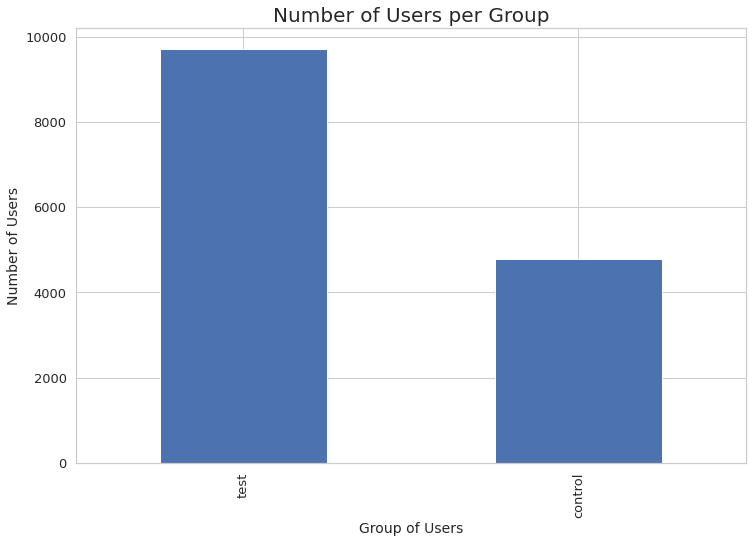

In [8]:
# Number of Users in the Test and Control Groups

dating_data_df['group'].replace({0: "control", 1: "test"}).value_counts().plot.bar()
plt.xlabel("Group of Users")
plt.ylabel("Number of Users")
plt.title("Number of Users per Group")
plt.show()

In the test group, there are significantly more users than in the control group, which may not have been intended.

### ! It is necessary to recheck the traffic splitting system !

In [9]:
# Let's perform the necessary transformations to calculate metrics and conduct statistical tests
 
activity_by_user = dating_data_df \
    .groupby(['user_id_1', 'group']) \
    .agg({'is_match' : 'sum', 'user_id_2' : 'count'}) \
    .reset_index() \
    .rename(columns={'is_match' : 'sum_matches', 'user_id_2' : 'count_actions'}) \

In [10]:
# Let's calculate the conversion rate (Conversion Rate - CR) = sum_matches / count_actions * 100

activity_by_user = activity_by_user.assign(CR = 100*activity_by_user.sum_matches/activity_by_user.count_actions)

In [11]:
activity_by_user['group'] = activity_by_user['group'].replace({0: "control", 1: "test"})

In [12]:
activity_by_user.head()

,user_id_1,group,sum_matches,count_actions,CR
0,1,test,11,24,45.833333
1,2,test,7,16,43.750000
2,3,test,5,16,31.250000
3,4,control,2,9,22.222222
4,5,test,13,22,59.090909


## 3. Hypothesis testing

### 3.1 Actions

Let's examine how user activity changed depending on the application version.

We will consider "User Action_1" as the presence of the pair ID_user_1-ID_user_X in the application logs, regardless of whether there was a match for the pair.

Text(0.5, 1.0, 'The number of actions per user')

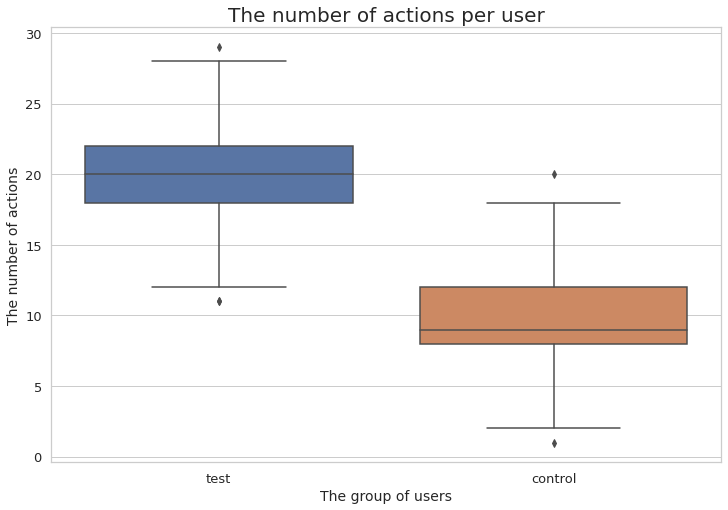

In [13]:
# The number of actions per user

sns.boxplot(x="group", y="count_actions", data=activity_by_user)
plt.xlabel("The group of users")
plt.ylabel("The number of actions")
plt.title("The number of actions per user")

On the graph, we can observe that the number of actions in the application with the new version of the algorithm has significantly increased. Let's check if the differences obtained are statistically significant. We will examine the distributions of the number of actions.

Text(0.5, 1.0, 'The distribution of the number of actions')

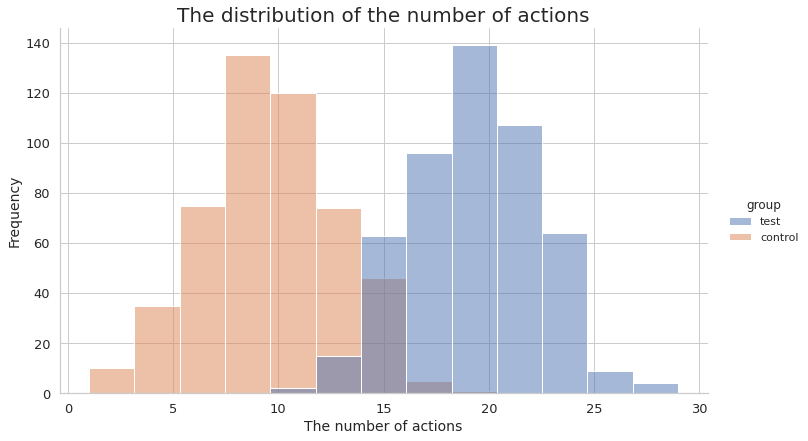

In [14]:
sns.displot(data=activity_by_user, x='count_actions', hue='group', kde=False, height=6, aspect=1.7)
plt.xlabel("The number of actions")
plt.ylabel("Frequency")
plt.title("The distribution of the number of actions")

Based on the graph, we can make an assumption that the distributions appear to be normal.

#### 3.1.1 Actions. Tests

The number of actions is a discrete variable. The choice of a statistical test will depend on the distribution properties.

Let's perform tests for normality and homogeneity.

In [15]:
# Shapiro-Wilk Test for Normality

pg.normality(data=activity_by_user, dv="count_actions", group="group", method="normaltest")

,W,pval,normal
test,4.262189,0.118707,True
control,2.406168,0.300267,True


The distributions in the test and control groups are normal.
Let's test the samples for homogeneity.

In [16]:
# test for equality of variances 

pg.homoscedasticity(data=activity_by_user, dv="count_actions", group="group")

,W,pval,equal_var
levene,0.480454,0.488378,True


Since the samples are normally distributed and have equivalent variances, we will use the parametric paired t-test (Student's t-test).

    H0 (null hypothesis) - The number of actions is not dependent on the application version.
    H1 (alternative hypothesis) - In the new version of the application, users perform more actions.

In [17]:
result = ttest_ind(
    activity_by_user[activity_by_user.group=="test"].count_actions,
    activity_by_user[activity_by_user.group=="control"].count_actions
)

In [18]:
p = result.pvalue
p

1.8942877064043142e-285

In [19]:
# Let's set the significance level alpha = 0.05.

prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Rejecting H0.')
else:
    print('Rejecting H1.')

Rejecting H0.


#### 3.1.2 Actions. Conclusion

The change is statistically significant, in the new version of the application, users started performing more actions.

In [20]:
# Mean, Median, Minimum, Maximum number of actions per user by groups.

activity_by_user.groupby(['group']).agg({'count_actions' : ['mean', 'median', 'min', 'max']})

count_actions               
                 mean median min max
group                               
control      9.564870      9   1  20
test        19.482966     20  11  29

### 3.2. Conversion rate per group

Let's examine how user activity changed depending on the application version.

We will consider the ratio of the number of actions to matches by user groups.

For comparing click-through rates and conversions, the Pearson's chi-square test is suitable. We will prepare a contingency table.

In [21]:
cross_t = pd.crosstab(dating_data_df.group, dating_data_df.is_match)\
    .rename(columns={1 : 'matches', 0 : 'actions'}) \
    .rename(index={1 : 'test', 0 : 'control'})
cross_t

is_match,actions,matches
group,,
control,3858,934
test,5813,3909


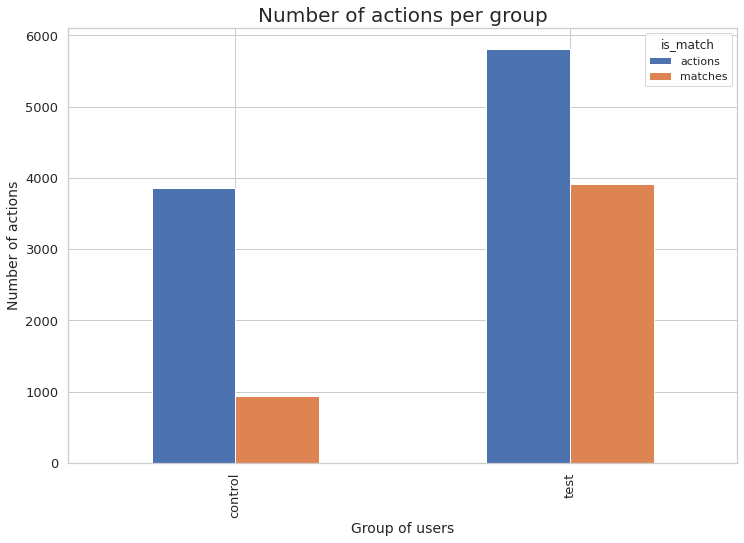

In [22]:
fig, ax = plt.subplots()
cross_t.plot(kind='bar', ax=ax)
plt.xlabel("Group of users")
plt.ylabel("Number of actions")
plt.title("Number of actions per group")
plt.show()

Users became more active in the application with the new algorithm, and the number of matches also significantly increased.

#### 3.2.1. Conversion rate per group. Tests

Let's analyze the obtained contingency table and check if the differences are statistically significant.

In the contingency table, each cell has more than 10 observations.
To assess the statistical significance of the differences, we will use the Pearson's chi-square test.

Let's state the hypotheses:

    H0 (null hypothesis) - The ratio of actions to matches is not dependent on the group;
    H1 (alternative hypothesis) - In the test group, the conversion rate has increased..

In [23]:
stat, p, dof, expected = chi2_contingency(cross_t)
p

1.4418299163662586e-136

In [24]:
# Let's set the significance level alpha = 0.05.

prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Reject H0.')
else:
    print('Reject H1')

Reject H0.


#### 3.2.2. Conversion rate per group. Conclusion

The change is statistically significant - in the new version of the application, a statistically significant increase in the conversion rate metric has been observed.

In [25]:
cross_t

is_match,actions,matches
group,,
control,3858,934
test,5813,3909


## 3.3. Conversion rate per user

    - Conversion rate per user = Matches/Actions.

Let's examine how the conversion rate changed depending on the application version.

Text(0.5, 1.0, 'Conversion rate (CR) - Matches/Actions')

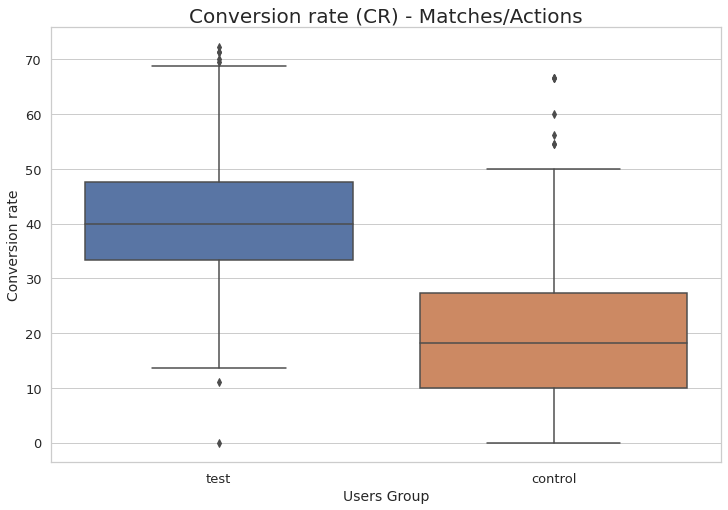

In [26]:
# Conversion rate - Matches/Actions

sns.boxplot(x="group", y="CR", data=activity_by_user)
plt.xlabel("Users Group")
plt.ylabel("Conversion rate")
plt.title("Conversion rate (CR) - Matches/Actions")

Text(0.5, 1.0, 'Conversion rate distribution')

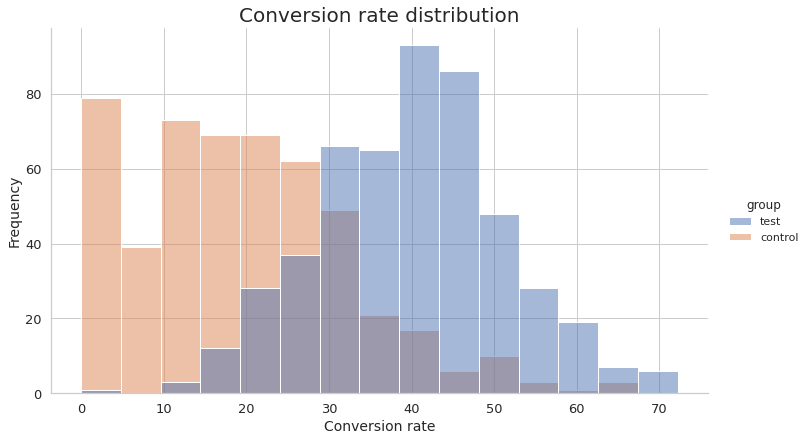

In [27]:
sns.displot(data=activity_by_user, x='CR', hue='group', kde=False, height=6, aspect=1.7)
plt.xlabel("Conversion rate")
plt.ylabel("Frequency")
plt.title("Conversion rate distribution")

The graphs clearly show that the conversion rate in the application with the new algorithm version has significantly increased, as the distribution of the test group is shifted to the right along the X-axis.

Let's check if the obtained differences are statistically significant.

Since the distribution in the control group is not normal, we will also examine the QQ Plot for further analysis.

Text(0.5, 1.0, 'Conversion rate - Matches/Activity (Control Group)')

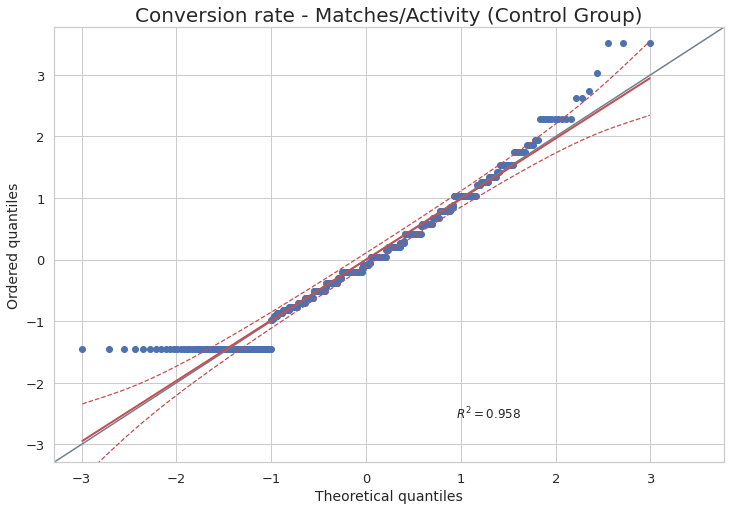

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))
pg.qqplot(activity_by_user[activity_by_user.group=="control"].CR, ax=ax)
ax.set_title("Conversion rate - Matches/Activity (Control Group)")

#### 3.3.1. Conversion rate per users. Tests.

Let's perform tests for normality and homogeneity.

In [29]:
# Shapiro-Wilk Test for Normality

pg.normality(data=activity_by_user, dv="CR", group="group", method="normaltest")

,W,pval,normal
test,0.273892,0.872017,True
control,24.051422,0.000006,False


Let's check the samples for homogeneity.

In [30]:
# test for equality of variances

pg.homoscedasticity(data=activity_by_user, dv="CR", group="group")

,W,pval,equal_var
levene,10.367478,0.001324,False


Correct, with a large sample size, the t-test becomes more robust to violations of normality and homogeneity. This allows us to use the t-test for testing hypotheses about differences in means even when the original data is non-normally distributed.

Let's use the parametric paired t-test (Student's t-test).

    H0 (null hypothesis) - The conversion rate is equivalent in the test and control groups.;
    H1 (alternative hypothesis) - In the test group, the conversion rate has increased.

In [31]:
result = ttest_ind(
    activity_by_user[activity_by_user.group=="test"].CR,
    activity_by_user[activity_by_user.group=="control"].CR
)

In [32]:
p = result.pvalue
p

4.842755754030156e-117

In [33]:
# Let's set the significance level alpha = 0.05.

prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Reject H0')
else:
    print('Reject H1')

Reject H0


#### 3.3.2. Conversion rate. Conclusion

The change is statistically significant; in the new version of the application, the mean conversion rate has increased.

In [34]:
# Mean, Median, Minimum, Maximum conversion rate per groups.

activity_by_user.groupby(['group']).agg({'CR' : ['mean', 'median', 'min', 'max']})

CR                           
              mean     median  min        max
group                                        
control  19.409911  18.181818  0.0  66.666667
test     40.234484  40.000000  0.0  72.222222

## 4. Summary

In the new version of the application, there has been a statistically significant increase in the average number of actions performed by users in test group.

Furthermore, the conversion rate has also significantly increased for test group, along with the average metric values across users.

Considering the observed statistically significant growth in the target metrics, it is recommended to deploy the new profile search system for all users in commercial operation.